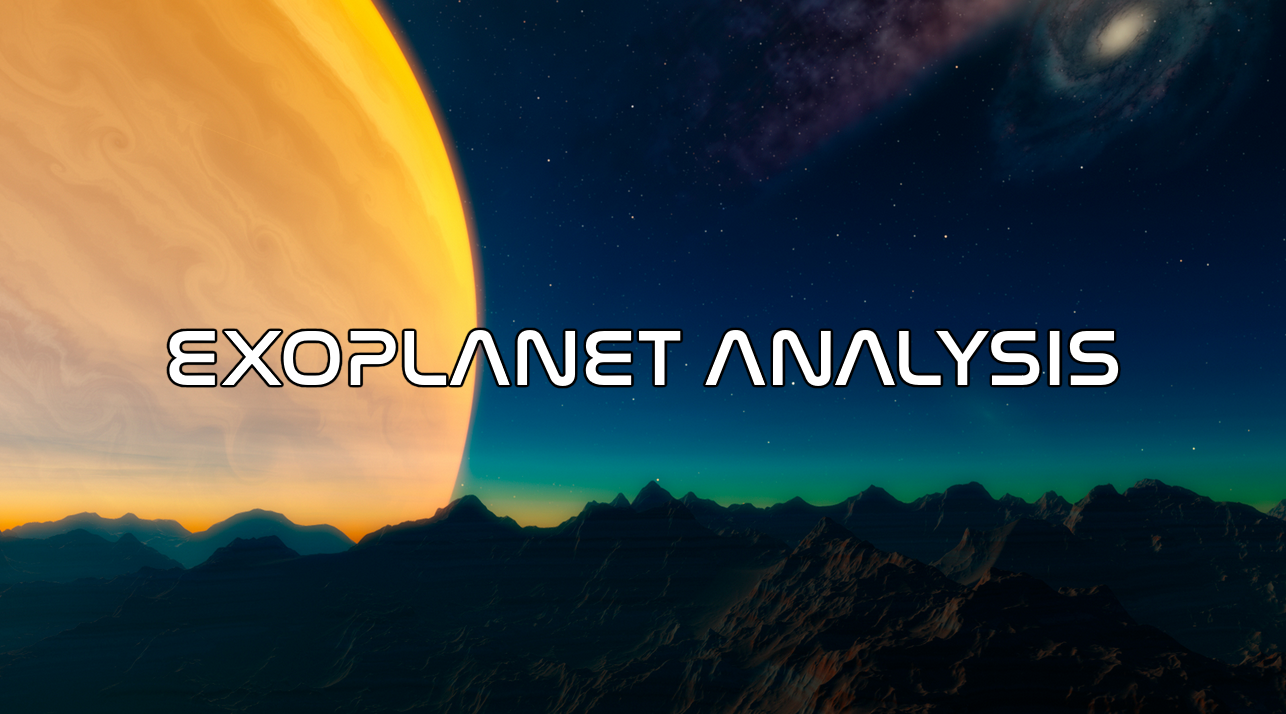

We will analyse the distributions of various extrasolar planets. We will group them into separate clusters, calculate missing information, find the most extreme known planets, and make predictions about the future.

Data has been retrieved from the NASA Exoplanet Archive on the following link:
https://exoplanetarchive.ipac.caltech.edu/cgi-bin/TblView/nph-tblView?app=ExoTbls&config=PS


Firstly, we import the necessary libraries:

In [ ]:
import pandas as pd
import numpy as np
import os
import random

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

from math import pi
import math

from pandas.io.html import read_html
from urllib.error import HTTPError
import urllib.request

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering

sns.set(rc={"figure.figsize":(10, 4)})

pd.set_option('display.max_columns', None)

The data has been retrieved  and is located on my google disk. Let us download it:

In [ ]:
url = 'https://drive.google.com/uc?id=10leqQFcOz8GvXn6eUmJ9mx6Iph2goQ3e&export=download&confirm=t'
filename = 'exoplanets.csv'
urllib.request.urlretrieve(url, filename)

('exoplanets.csv', <http.client.HTTPMessage at 0x7fbc0fca7d60>)

## **Loading the Data**

In [ ]:
exoplanets = pd.read_csv('exoplanets.csv', parse_dates=[90])

<ipython-input-3-a18dadb00379>:1: DtypeWarning: Columns (34,49,66) have mixed types. Specify dtype option on import or set low_memory=False.
  exoplanets = pd.read_csv('exoplanets.csv', parse_dates=[90])
<ipython-input-3-a18dadb00379>:1: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  exoplanets = pd.read_csv('exoplanets.csv', parse_dates=[90])


We are dropping all data that does not concern the planet, the star or the system it is orbiting in. Exoplanet research is a relatively new field, and with less than 6000 confirmed exoplanets, there are many inaccuracies and insecurities concerning the general exoplanet population. Nevertheless, the data that is available can paint an interesting picture. We will be removing all upper and lower limits of data as well.

In [ ]:
columnsToDrop = ["soltype", "pl_refname", "pl_controv_flag", "st_refname", "sy_refname", "rastr", "ra", "decstr", "dec", "rowupdate", "pl_pubdate", "pl_bmasseerr2", "pl_bmasseerr1",
                 "pl_orbpererr1", "pl_orbpererr2", "pl_orbperlim", "sy_vmagerr1", "sy_vmagerr2", "sy_kmagerr1", "sy_kmagerr2", "sy_gaiamagerr1", "sy_gaiamagerr2", "releasedate",
                 "sy_disterr1", "sy_disterr2", "st_loggerr1", "st_loggerr2", "st_logglim", "st_meterr1", "st_meterr2", "st_metlim", "pl_orbsmaxerr1", "pl_orbsmaxerr2", "pl_orbsmaxlim",
                 "pl_radj", "pl_radjerr1", "pl_radjerr2", "pl_radjlim", "pl_orbeccenerr1", "pl_orbeccenerr2", "pl_orbeccenlim", "pl_bmassj", "pl_bmassjerr1", "pl_bmassjerr2", "pl_bmassjlim",
                 "st_masserr1", "st_masserr2", "st_masslim", "pl_orbeccenlim", "pl_insol", "pl_insolerr1", "pl_insolerr2", "pl_insollim", "st_tefferr1", "pl_bmassprov", "pl_radeerr1", "pl_radeerr2",
                 "st_tefferr2", "st_tefflim", "st_raderr1", "st_raderr2", "st_radlim", "pl_eqterr1", "pl_eqterr2", "pl_eqtlim", "sy_vmag", "sy_kmag", "sy_gaiamag", "pl_bmasselim", "pl_radelim", "ttv_flag",
                 "st_logg", "st_metratio", "st_met" ]
exoplanets.drop(axis=1, labels=columnsToDrop, inplace=True)

Lets see what data remains within our dataset.

In [ ]:
exoplanets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33829 entries, 0 to 33828
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   pl_name          33829 non-null  object 
 1   hostname         33829 non-null  object 
 2   sy_snum          33829 non-null  int64  
 3   sy_pnum          33829 non-null  int64  
 4   discoverymethod  33829 non-null  object 
 5   disc_year        33829 non-null  int64  
 6   disc_facility    33829 non-null  object 
 7   pl_orbper        30957 non-null  float64
 8   pl_orbsmax       18521 non-null  float64
 9   pl_rade          23383 non-null  float64
 10  pl_bmasse        5043 non-null   float64
 11  pl_orbeccen      16923 non-null  float64
 12  pl_eqt           15396 non-null  float64
 13  st_spectype      1976 non-null   object 
 14  st_teff          31421 non-null  float64
 15  st_rad           31541 non-null  float64
 16  st_mass          28555 non-null  float64
 17  sy_dist     

Features starting in “pl” relate to the planet, those that start with “st” relate to the star the planet orbits, and “sy” to the exoplanet system.
*   pl_name, pl_orbper, pl_orbsmax, pl_rade, pl_bmasse, pl_orbeccen, pl_eqt are: the name, orbital period, orbital distance, planet's radius, planet's mass, orbital eccentricity, and the equilibrium temperature. These values (except the temperature) are expressed in Earth units.
*   hostname - the name of the parent star
* sy_snum, sy_pnum, sy_dist are: the number of stars within the system, the number of other known exoplanets in the system, and the system's distance to Earth.
* discoverymethod, disc_year, disc_facility are: the method of exoplanet's discovery, the year of its discovery, and the science facility that discovered it.
* st_specttype, st_teff, st_rad, st_mass are: the parent star's spectral type, its temperature, radius, and mass. These values (except the temperature) are expressed in Solar units.




## **Cleaning the Data**
We will be converting data to other types to speed up execution time and reduce the space occupied by the dataset. As well as calculating additional features.

In [ ]:
# categorical data
exoplanets['discoverymethod'] = exoplanets['discoverymethod'].astype('category')
exoplanets['disc_facility'] = exoplanets['disc_facility'].astype('category')

# numberical data
exoplanets['sy_snum'] = exoplanets['sy_snum'].astype('int8')
exoplanets['sy_pnum'] = exoplanets['sy_pnum'].astype('int8')
exoplanets['disc_year'] = exoplanets['disc_year'].astype('int16')

When we take a look at the dateset now:

In [ ]:
exoplanets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33829 entries, 0 to 33828
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   pl_name          33829 non-null  object  
 1   hostname         33829 non-null  object  
 2   sy_snum          33829 non-null  int8    
 3   sy_pnum          33829 non-null  int8    
 4   discoverymethod  33829 non-null  category
 5   disc_year        33829 non-null  int16   
 6   disc_facility    33829 non-null  category
 7   pl_orbper        30957 non-null  float64 
 8   pl_orbsmax       18521 non-null  float64 
 9   pl_rade          23383 non-null  float64 
 10  pl_bmasse        5043 non-null   float64 
 11  pl_orbeccen      16923 non-null  float64 
 12  pl_eqt           15396 non-null  float64 
 13  st_spectype      1976 non-null   object  
 14  st_teff          31421 non-null  float64 
 15  st_rad           31541 non-null  float64 
 16  st_mass          28555 non-null  float64

The dataset size has been reduced by 1.3 MB.
Now, lets take a look at our data:

In [ ]:
exoplanets.head()

,pl_name,hostname,sy_snum,sy_pnum,discoverymethod,disc_year,disc_facility,pl_orbper,pl_orbsmax,pl_rade,pl_bmasse,pl_orbeccen,pl_eqt,st_spectype,st_teff,st_rad,st_mass,sy_dist
0,Kepler-10 b,Kepler-10,1,2,Transit,2011,Kepler,0.837500,NaN,2.005,NaN,NaN,1987.0,NaN,5706.00,1.09,NaN,185.5060
1,Kepler-102 e,Kepler-102,1,5,Transit,2013,Kepler,16.145590,NaN,3.563,NaN,NaN,536.0,NaN,4816.00,0.73,NaN,107.7960
2,Kepler-1651 b,Kepler-1651,2,1,Transit,2017,Kepler,9.878684,NaN,2.108,NaN,NaN,412.0,NaN,3759.27,0.46,NaN,66.4074
3,Kepler-210 c,Kepler-210,1,2,Transit,2014,Kepler,7.972664,NaN,3.793,NaN,NaN,608.0,NaN,4564.61,0.64,NaN,232.7500
4,Kepler-37 d,Kepler-37,1,4,Transit,2013,Kepler,79.583999,NaN,1.975,NaN,NaN,355.0,NaN,5391.00,0.79,NaN,63.9207


And a specific planet:

In [ ]:
exoplanets.loc[exoplanets['pl_name'] == "TRAPPIST-1 b"]

,pl_name,hostname,sy_snum,sy_pnum,discoverymethod,disc_year,disc_facility,pl_orbper,pl_orbsmax,pl_rade,pl_bmasse,pl_orbeccen,pl_eqt,st_spectype,st_teff,st_rad,st_mass,sy_dist
114,TRAPPIST-1 b,TRAPPIST-1,1,7,Transit,2016,La Silla Observatory,1.510884,0.011534,NaN,NaN,NaN,398.0,NaN,2520.0,0.12,0.09,NaN
115,TRAPPIST-1 b,TRAPPIST-1,1,7,Transit,2016,La Silla Observatory,1.510826,0.011540,1.116,1.374,NaN,NaN,NaN,2566.0,0.12,0.09,NaN
3123,TRAPPIST-1 b,TRAPPIST-1,1,7,Transit,2016,La Silla Observatory,NaN,0.011548,1.121,1.017,0.00622,NaN,NaN,NaN,NaN,0.09,NaN
15455,TRAPPIST-1 b,TRAPPIST-1,1,7,Transit,2016,La Silla Observatory,1.510871,0.011110,1.086,0.850,0.08100,400.0,NaN,2559.0,0.12,0.08,NaN
15715,TRAPPIST-1 b,TRAPPIST-1,1,7,Transit,2016,La Silla Observatory,NaN,NaN,NaN,NaN,NaN,366.0,NaN,NaN,0.11,0.09,NaN
20244,TRAPPIST-1 b,TRAPPIST-1,1,7,Transit,2016,La Silla Observatory,1.510848,0.011110,1.113,NaN,0.00000,400.0,NaN,2550.0,0.12,0.08,NaN


Here we see that there are multiple entries for each exoplanet. This is because the exoplanet archive keeps track of previous entries. We need a way to reduce the data down into one entry per planet.

The logic behind how we will do this is as follows:
1. We will create a separate dataframe, called "temp1" which contains the most recent data for each planet.
2. We will create another dataframe, called "temp2" that contains all other entries.
3. temp2, with its other entries, will be reduced to one entry per planet, taking the average of each column. In this way, we get the “most agreed upon” value for each data point.
4. We will merge the two dataframes, keeping only the “first” data point per each column, for each exoplanet.

In summary, we will take the most recent value provided, if thet value is missing, we will take the average of all older values.


In [ ]:
temp1 = exoplanets.copy()
temp1.drop_duplicates(subset=["pl_name"], inplace=True, ignore_index=True)

Lets check this dataset really does contain only the newest datapoints for each planet.

In [ ]:
temp1.loc[temp1['hostname'] == "TRAPPIST-1"]

,pl_name,hostname,sy_snum,sy_pnum,discoverymethod,disc_year,disc_facility,pl_orbper,pl_orbsmax,pl_rade,pl_bmasse,pl_orbeccen,pl_eqt,st_spectype,st_teff,st_rad,st_mass,sy_dist
88,TRAPPIST-1 b,TRAPPIST-1,1,7,Transit,2016,La Silla Observatory,1.510884,0.011534,NaN,NaN,NaN,398.0,NaN,2520.0,0.12,0.09,NaN
89,TRAPPIST-1 c,TRAPPIST-1,1,7,Transit,2016,La Silla Observatory,2.421793,0.015790,NaN,NaN,NaN,340.0,NaN,2520.0,0.12,0.09,NaN
90,TRAPPIST-1 d,TRAPPIST-1,1,7,Transit,2016,La Silla Observatory,4.049780,0.022260,NaN,NaN,NaN,286.0,NaN,2520.0,0.12,0.09,NaN
91,TRAPPIST-1 e,TRAPPIST-1,1,7,Transit,2017,Multiple Observatories,6.099565,0.029240,NaN,NaN,NaN,250.0,NaN,2520.0,0.12,0.09,NaN
92,TRAPPIST-1 f,TRAPPIST-1,1,7,Transit,2017,Multiple Observatories,9.207540,0.038490,1.045,1.039,NaN,NaN,NaN,2566.0,0.12,0.09,NaN
93,TRAPPIST-1 g,TRAPPIST-1,1,7,Transit,2017,Multiple Observatories,12.352446,0.046830,1.129,1.321,NaN,NaN,NaN,2566.0,0.12,0.09,NaN
94,TRAPPIST-1 h,TRAPPIST-1,1,7,Transit,2017,Multiple Observatories,18.772866,0.061890,0.755,0.326,NaN,NaN,NaN,2566.0,0.12,0.09,NaN


Now, we create a dataframe that contains all older datapoints.

In [ ]:
temp2 = exoplanets.copy()
temp2 = temp2[temp2.duplicated('pl_name') | ~temp2.duplicated('pl_name', keep=False)]
temp2= temp2.groupby('pl_name').mean()
temp2.reset_index(inplace=True)

<ipython-input-12-85d22ec4918d>:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  temp2= temp2.groupby('pl_name').mean()


In [ ]:
temp2.loc[temp2['pl_name'] == "TRAPPIST-1 b"]

,pl_name,sy_snum,sy_pnum,disc_year,pl_orbper,pl_orbsmax,pl_rade,pl_bmasse,pl_orbeccen,pl_eqt,st_teff,st_rad,st_mass,sy_dist
4947,TRAPPIST-1 b,1.0,7.0,2016.0,1.510848,0.011327,1.109,1.080333,0.029073,388.666667,2558.333333,0.1175,0.086,NaN


We see in the cell above that this dataframe does indeed contain the average of all older datapoints.

In [ ]:
temp1 = pd.concat([temp1, temp2], ignore_index=True)

In [ ]:
temp1.loc[temp1['pl_name'] == "TRAPPIST-1 b"]

,pl_name,hostname,sy_snum,sy_pnum,discoverymethod,disc_year,disc_facility,pl_orbper,pl_orbsmax,pl_rade,pl_bmasse,pl_orbeccen,pl_eqt,st_spectype,st_teff,st_rad,st_mass,sy_dist
88,TRAPPIST-1 b,TRAPPIST-1,1.0,7.0,Transit,2016.0,La Silla Observatory,1.510884,0.011534,NaN,NaN,NaN,398.000000,NaN,2520.000000,0.1200,0.090,NaN
10174,TRAPPIST-1 b,NaN,1.0,7.0,NaN,2016.0,NaN,1.510848,0.011327,1.109,1.080333,0.029073,388.666667,NaN,2558.333333,0.1175,0.086,NaN


Within the temp1 dataframe we now have two rows for each planet. The first contains the newest data, and the second contains the average of the remaining rows. We will now take the "first" datapoint of each column for each exoplanet.

In [ ]:
exoplanets = temp1.groupby('pl_name').first()
exoplanets.reset_index(inplace=True)

Lets take a look at one of the planets:

In [ ]:
exoplanets.loc[exoplanets['pl_name'] == "TRAPPIST-1 b"]

,pl_name,hostname,sy_snum,sy_pnum,discoverymethod,disc_year,disc_facility,pl_orbper,pl_orbsmax,pl_rade,pl_bmasse,pl_orbeccen,pl_eqt,st_spectype,st_teff,st_rad,st_mass,sy_dist
4947,TRAPPIST-1 b,TRAPPIST-1,1.0,7.0,Transit,2016.0,La Silla Observatory,1.510884,0.011534,1.109,1.080333,0.029073,398.0,None,2520.0,0.12,0.09,NaN


How many values we are still missing?

In [ ]:
exoplanets.isnull().sum(axis = 0)

pl_name               0
hostname              0
sy_snum               0
sy_pnum               0
discoverymethod       0
disc_year             0
disc_facility         0
pl_orbper           184
pl_orbsmax          281
pl_rade            1223
pl_bmasse          2831
pl_orbeccen         675
pl_eqt             1354
st_spectype        4684
st_teff             325
st_rad              453
st_mass              27
sy_dist             114
dtype: int64

Some missing values can be calculated, some can be found on the internet. First, lets handle orbital period and orbital distance.

The orbital distance (pl_orbsmax) and orbital period (pl_orbper) are closely related with Kepler's Third Law:

$P^2=a^2*M$

*P = Period in years*<br>*a = semi major axis (SMA) in AU*<br>*M = mass of the star in solar masses*

In [ ]:
exoplanets[(exoplanets.pl_orbper.notnull() & exoplanets.pl_orbsmax.isnull() & exoplanets.st_mass.notnull())].pl_name.count()  +exoplanets[(exoplanets.pl_orbper.isnull() & exoplanets.pl_orbsmax.notnull() & exoplanets.st_mass.notnull())].pl_name.count()

438

We have 438 planets with either a missing period or distance, and the other parameter available. We can calculate them both using the following functions:

In [ ]:
def calcSMA(Period, solarMass):
  return round(((Period**2)*solarMass)**(1/3),5)

def calcPeriod(SMA, solarMass):
  return round(((SMA**3)/solarMass)**(0.5),5)

We will create temporary dataframes to calcualte the missing values and add them back into our original dataframe.

In [ ]:
temp1 = exoplanets[(exoplanets.pl_orbper.notnull() & exoplanets.pl_orbsmax.isnull() & exoplanets.st_mass.notnull())].copy()
temp1.pl_orbsmax = calcSMA(temp1.pl_orbper/365.25, temp1.st_mass)
exoplanets = pd.concat([exoplanets, temp1], ignore_index=True)
exoplanets.drop_duplicates(subset=["pl_name"], keep='last', inplace=True, ignore_index=True)

In [ ]:
temp1 = exoplanets[(exoplanets.pl_orbper.isnull() & exoplanets.pl_orbsmax.notnull() & exoplanets.st_mass.notnull())].copy()
temp1.pl_orbper = calcPeriod(temp1.pl_orbsmax, temp1.st_mass)*365.25
exoplanets = pd.concat([exoplanets, temp1], ignore_index=True)
exoplanets.drop_duplicates(subset=["pl_name"], keep='last', inplace=True, ignore_index=True)

In [ ]:
exoplanets[(exoplanets.pl_orbper.notnull() & exoplanets.pl_orbsmax.isnull() & exoplanets.st_mass.notnull())].pl_name.count() + exoplanets[(exoplanets.pl_orbper.isnull() & exoplanets.pl_orbsmax.notnull() & exoplanets.st_mass.notnull())].pl_name.count()

0

We no longer have any planets with either a missing SMA or orbital period. There are systems which are missing their distance to the sun. We can find these distances using web-scraping. We will check the wiki page of each star and retrieve its distance to the sun.

The function for this is defined below:

In [ ]:
def findDistance(hostname):
  page = 'https://en.wikipedia.org/wiki/NAMESYS'
  page = page.replace("NAMESYS", hostname)
  page = page.replace(" ", "%20")
  try:
    try:
      infoboxes = read_html(page, index_col=0, attrs={"class":"infobox"})

      try:
        distance1 = infoboxes[0].xs(u'Distance').values[0]
        distance2 = ''.join([str(elem) for elem in distance1]).replace(",", ".").replace(" ", " ").replace("approx. ", "")
        distance3 = round(float(distance2.lstrip().split(' ')[0])*0.3066,4)
        return distance3
      except KeyError as err:
        #print(f"{err} during the search for {hostname}")
        return None

    except ValueError as err:
      #print(f"{err} during the search for {hostname}")
      return None

  except HTTPError as err:
    if err.code == 404:
      #print(f"Cannot find the wiki page for {hostname}")
      return None
    else:
      raise

In [ ]:
temp1 = exoplanets[exoplanets.sy_dist.isnull()].copy()
temp1["sy_dist"] = temp1.hostname.apply(lambda x: findDistance(x))
nFound = temp1[temp1.sy_dist.notnull()].groupby('hostname').first().pl_name.count()
exoplanets = pd.concat([exoplanets, temp1], ignore_index=True)
exoplanets.drop_duplicates(subset=["pl_name"], keep='last', inplace=True, ignore_index=True)
print(f"{nFound} previously unknown system distances found")

14 previously unknown system distances found


Lets try finding the star spectral types as well.

In [ ]:
temp1 = exoplanets.groupby("hostname").first()["st_spectype"].isnull().sum()
print(f"{temp1} stars are missing their spectral type.")

3503 stars are missing their spectral type.


In [ ]:
def findStarType(hostname):
  page = 'https://en.wikipedia.org/wiki/NAMESYS'
  page = page.replace("NAMESYS", hostname)
  page = page.replace(" ", "%20")
  try:
    try:
      infoboxes = read_html(page, index_col=0, attrs={"class":"infobox"})

      try:
        value = infoboxes[0].xs(u'Spectral type').values[0]
        return value
      except KeyError as err:
        #print(f"{err} during the search for {hostname}")
        return None

    except ValueError as err:
      #print(f"{err} during the search for {hostname}")
      return None

  except HTTPError as err:
    if err.code == 404:
      #print(f"Cannot find the wiki page for {hostname}")
      return None
    else:
      raise

In [ ]:
# scrapedStarTypes = exoplanets[exoplanets.st_spectype.isnull()].copy()
# scrapedStarTypes["st_spectype"] = scrapedStarTypes.hostname.apply(lambda x: findStarType(x))
# temp2 = scrapedStarTypes[scrapedStarTypes.st_spectype.notnull()].groupby('hostname').first().pl_name.count()

# print(f"{temp2} previously unknown star types found")

The cell above takes a long time to execute, around 40 minutes. So we will just load its result with the cell below. You can run the cell above if you wish, but you need to skip the one immediately below.

In [ ]:
urllib.request.urlretrieve("https://drive.google.com/uc?id=1xbGiJaON0zst06uv3_2O1tyjYosvMWHg&export=download", "scrapedStarTypes.csv")
scrapedStarTypes = pd.read_csv('scrapedStarTypes.csv', index_col=0)
scrapedStarTypes = scrapedStarTypes.reset_index(level=0)

Lets add the found stars into our dataset.

In [ ]:
exoplanets = pd.concat([exoplanets, scrapedStarTypes], ignore_index=True)
exoplanets.drop_duplicates(subset=["pl_name"], keep='last', inplace=True, ignore_index=True)
exoplanets["st_spectype"] = exoplanets.st_spectype.astype(str)
exoplanets["st_spectype"] = exoplanets.st_spectype.apply(lambda x: str(x[:2]))
exoplanets["st_spectype"] = exoplanets.st_spectype.apply(lambda x: None if x == "No" else x)
exoplanets.st_spectype = exoplanets.st_spectype.apply(lambda x: None if x=="na" else x)

In [ ]:
temp2 = exoplanets.groupby("hostname").first()["st_spectype"].isnull().sum()
print(f"{temp2} stars are missing their spectral type. We found {temp1-temp2} missing star types")

3228 stars are missing their spectral type. We found 275 missing star types


An important property of planets is the Equilibrium Temperature. It can be calcualted using the temperature and the radius of the parent star, the distance to the planet, and its albedo.
Source:https://www.astro.princeton.edu/~strauss/FRS113/writeup3/

We will be assuming an Albedo value of 0.28.

Lets see how many planets are missing their Equilibrium Temperatures.

In [ ]:
exoplanets[exoplanets.st_teff.notnull() & exoplanets.pl_eqt.isnull() & exoplanets.st_rad.notnull() & exoplanets.pl_orbsmax.notnull()].pl_name.count()

905

For these planets we will calculate the Equilibrium Temperature with the following function:

In [ ]:
def calculateEQTemperature(solarRadi, SMAinAU, T):
  R = solarRadi * 696340
  SMA = SMAinAU * 150000000
  Albedo = 0.28
  return T*((R/(SMA*2))**(0.5))*((1-Albedo)**(1/4))

Lets see how well our equation performs on planets for which we know the equilibrium temperature:

In [ ]:
eligible= exoplanets[exoplanets.st_teff.notnull() & exoplanets.pl_eqt.notnull() & exoplanets.st_rad.notnull() & exoplanets.pl_orbsmax.notnull()].pl_name.count()
eligible

3841

We will perform the check with 3841 planets. We will create a separate dataframe to perform the calculation. We will calculate a delta temperature - a percentage value that tells us how wrong our calculated value is. We will then see how many planets fall within 10% of the expected value.

In [ ]:
checkTemp = exoplanets[exoplanets.st_teff.notnull() & exoplanets.pl_eqt.notnull() & exoplanets.st_rad.notnull() & exoplanets.pl_orbsmax.notnull()].copy()
checkTemp["calculatedTemp"] = calculateEQTemperature(checkTemp.st_rad, checkTemp.pl_orbsmax, checkTemp.st_teff)
checkTemp["deltaTemp"] = checkTemp.pl_eqt/checkTemp.calculatedTemp
within10 = checkTemp[(checkTemp.deltaTemp > 0.9) & (checkTemp.deltaTemp < 1.1)].pl_name.count()
within1 = checkTemp[(checkTemp.deltaTemp > 0.99) & (checkTemp.deltaTemp < 1.01)].pl_name.count()
print(f"Of {eligible} planets, {within10/eligible:2.1%} fall within 10% of the real value. {within1/eligible:2.1%} within 1%")

Of 3841 planets, 79.5% fall within 10% of the real value. 23.5% within 1%


These values are acceptable, and we move forward with the calculation. We will calculate the missing values in a separate dataframe, concat it back into exoplanets, and keep the last row which contains the temperature.

In [ ]:
temp1 = exoplanets[exoplanets.st_teff.notnull() & exoplanets.pl_eqt.isnull() & exoplanets.st_rad.notnull() & exoplanets.pl_orbsmax.notnull()].copy()
temp1.pl_eqt = calculateEQTemperature(temp1.st_rad, temp1.pl_orbsmax, temp1.st_teff)
exoplanets = pd.concat([exoplanets, temp1], ignore_index=True)
exoplanets.drop_duplicates(subset=["pl_name"], keep='last', inplace=True, ignore_index=True)

Lets see how many eligible planets are missing their eq temperature now:

In [ ]:
exoplanets[exoplanets.st_teff.notnull() & exoplanets.pl_eqt.isnull() & exoplanets.st_rad.notnull() & exoplanets.pl_orbsmax.notnull()].pl_name.count()

0

For the following missing values, we have no way of calculating, or retrieving them from elsewhere on the internet. We can however, calculate new variables that can be useful in our analysis.

In [ ]:
exoplanets.isnull().sum(axis = 0)

pl_name               0
hostname              0
sy_snum               0
sy_pnum               0
discoverymethod       0
disc_year             0
disc_facility         0
pl_orbper            11
pl_orbsmax           16
pl_rade            1223
pl_bmasse          2831
pl_orbeccen         675
pl_eqt              449
st_spectype        4266
st_teff             325
st_rad              453
st_mass              27
sy_dist              92
ttv_flag           1509
dtype: int64

One of these useful variables, is the Earth Similarity Index. A scalar that attempts to reduce the dimensionality of the differences of planetary characteristic when compared to Earth. In other words, the closer the ESI value is to 1, the closer that planet is to being Earth.

It is explained in the *Earth Similarity Index and Habitability Studies of Exoplanets* paper.

*Earth Similarity Index and Habitability Studies of Exoplanets*: https://arxiv.org/ftp/arxiv/papers/1801/1801.07101.pdf

One of the variables needed for ESI, is the surface temperature. We can approximate it with the equation given in the paper above:

In [ ]:
def calculateSurfaceTemp(pl_eqt):
  return 9.65 + 1.096 * pl_eqt

In [ ]:
exoplanets["pl_sut"] = calculateSurfaceTemp(exoplanets.pl_eqt)
col = exoplanets.pop("pl_sut")
exoplanets.insert(13, col.name, col)

The surface temperatures have been calculated and moved to an appropriate position in the dataframe.

Next, we calculate the density of planets for which we know the mass and radius. All we need is the equation for the volume of the sphere, and the relationship between density, mass and volume:

$V = \frac{{4\pi r^3 }}{3}$<br>*V - volume*<br>*r - radius*

$D = \frac{M}{V}$<br>*D - density*<br>*M - mass*<br>*V - volume*


In [ ]:
def calculateDensity(pl_bmasse, pl_rade):
  pl_volume = 4/3*3.14159*(pl_rade**3)
  return pl_bmasse/pl_volume*4.1888

exoplanets["pl_dens"] = calculateDensity(exoplanets.pl_bmasse, exoplanets.pl_rade)
col = exoplanets.pop("pl_dens")
exoplanets.insert(11, col.name, col)

An escape velocity of a planet is the minimum speed an object needs to escape the planet's gravity.

$V_e = \sqrt \frac{2GM}{r}$<br>
*$V_e$ - escape velocity*<br>*M - mass*<br>*G - gravitational constant ($6.6743 × 10^{-11}$)*

In [ ]:
def calculateEscVelocity(M, R):
  G = 6.67*10**-11
  EscV = (2*G*M/R)**(0.5)
  return EscV*86580.8978

In [ ]:
exoplanets["pl_escv"] = calculateEscVelocity(exoplanets.pl_bmasse, exoplanets.pl_rade)
col = exoplanets.pop("pl_escv")
exoplanets.insert(12, col.name, col)

We will also add the surface gravity to the equation:

$g_s = \frac{GM}{r^2}$<br>
*$g_s$ - surface gravity*<br>*M - mass*<br>*G - gravitational constant ($6.6743 × 10^{-11}$)*

In [ ]:
def calculateSurfaceGavity(pl_rade, pl_bmasse):
  mass = pl_bmasse*5.97*10**24
  radius = pl_rade*6371
  result = (6.674*10**-11*mass)/radius**2
  return result/1000000/9.816

In [ ]:
exoplanets["pl_sug"] = calculateSurfaceGavity(exoplanets.pl_rade, exoplanets.pl_bmasse).astype("float64").round(decimals = 3)
col = exoplanets.pop("pl_sug")
exoplanets.insert(13, col.name, col)

The following equation has been adapted from the ESI calculation provided in the *Earth Similarity Index and Habitability Studies of Exoplanets* document. It consists of three “sub-indexes”; ESIi, ESIg, and ESIt.

$ESIi = \sqrt{(1-|\frac{R-1}{1+R}|^{0.57})*(1-|\frac{D-1}{1+D}|^{1.07})}$<br>
*$ESIi$ - Earth Similarity Index of the planet's interior*  
  <br>
$ESIg = \sqrt{(1-|\frac{V_e-1}{1+V_e}|^{0.7})*(1-|\frac{g_s-1}{1+g_s}|^{1.3})}$<br>
*$ESIg$ - Earth Similarity Index of the planet's gravity*

<br>

$ESIt = (1-|\frac{T-1}{1+T}|)^{5.58}$<br>
*$ESIt$ - Earth Similarity Index of the planet's temperature*<br>
  <br>

*R - planet radius*<br>*D - planet density*<br>*$V_e$ - escape velocity*<br>*$g_s$ - surface gravity*<br>*T - surface temperature*
  <br>

$ESI = \sqrt[3]{ESIi * ESIg * ESIt}$<br>*$ESI$ - Earth Similarity Index*

In [ ]:
def calculateESI(T, EV, G, R, D):
  ESIi = (((1-abs(R-1)/abs(1+R))**0.57)*((1-abs(D-1)/abs(1+D))**1.07))**0.5
  ESIg = (((1-abs(EV-1)/abs(1+EV))**0.7)*((1-abs(G-1)/abs(1+G))**1.3))**0.5
  ESIt = (1-abs(T-288)/abs(288+T))**5.58
  return (ESIi*ESIg*ESIt)**(1/3)

In [ ]:
exoplanets["ESI"] = calculateESI(exoplanets.pl_sut, exoplanets.pl_escv, exoplanets.pl_sug, exoplanets.pl_rade, exoplanets.pl_dens)
col = exoplanets.pop("ESI")
exoplanets.insert(4, col.name, col)

Lets take a look at our feature-complete dataset:

In [ ]:
exoplanets.head()

,pl_name,hostname,sy_snum,sy_pnum,ESI,discoverymethod,disc_year,disc_facility,pl_orbper,pl_orbsmax,pl_rade,pl_bmasse,pl_dens,pl_escv,pl_sug,pl_orbeccen,pl_eqt,pl_sut,st_spectype,st_teff,st_rad,st_mass,sy_dist,ttv_flag
0,51 Eri b,51 Eri,3.0,1.0,NaN,Imaging,2015.0,Gemini Observatory,11688.000000,12.000000,NaN,635.660000,NaN,NaN,NaN,0.450000,700.0,776.850,None,7295.00,1.49,1.650000,29.7575,NaN
1,55 Cnc b,55 Cnc,2.0,5.0,NaN,Radial Velocity,1996.0,Lick Observatory,14.651710,0.116200,NaN,267.293690,NaN,NaN,NaN,0.004800,700.0,776.850,None,5317.89,0.96,0.970000,12.5855,NaN
2,55 Cnc e,55 Cnc,2.0,5.0,0.060848,Radial Velocity,2004.0,McDonald Observatory,0.736546,0.019644,1.915,8.673422,1.235053,2.128192,2.365,0.081625,1831.0,2016.426,None,5250.00,0.96,0.916923,12.5855,NaN
3,AB Pic b,AB Pic,1.0,1.0,NaN,Imaging,2005.0,Paranal Observatory,NaN,260.000000,NaN,4290.500000,NaN,NaN,NaN,NaN,NaN,NaN,K2,NaN,NaN,NaN,50.0475,NaN
4,AU Mic b,AU Mic,1.0,2.0,0.211262,Transit,2020.0,Transiting Exoplanet Survey Satellite (TESS),8.463070,0.064850,4.027,24.625880,0.377093,2.472892,1.519,0.089200,755.0,837.130,None,3588.00,0.70,0.500000,9.7221,NaN


## **Solar System Data**
Lets prepare the data for solar system planets too. This will be useful for comparison. The data has been collected from: https://www.kaggle.com/datasets/jaredsavage/solar-system-major-bodies-data

The data has also been manually adapted to earth units.

In [ ]:
urllib.request.urlretrieve("https://drive.google.com/uc?id=1ix2YDTpHo4Li3mcRg8ZAvlpqWa5ttnop&export=download", "solData.csv")
solData = pd.read_csv('solData.csv')

In [ ]:
solData["ESI"] = calculateESI(solData.pl_sut, solData.pl_escv, solData.pl_sug, solData.pl_rade, solData.pl_dens)

In [ ]:
solData

,pl_name,hostname,sy_snum,sy_pnum,eccentricity,pl_dens,pl_sug,pl_escv,pl_rade,pl_orbper,pl_bmasse,pl_orbsmax,pl_sut,ESI
0,Ceres,Sol,1,8,0.07582,0.391940,0.028571,0.045576,0.074745,1681.6300,0.00,2.765349,210,0.219253
1,Uranus,Sol,1,8,0.04570,0.230340,0.905102,1.910634,3.980851,30685.4000,14.54,19.189165,76,0.143560
2,Pluto,Sol,1,8,0.24880,0.342789,0.063265,0.108132,0.186517,90465.0000,0.00,39.482117,50,0.042986
3,Neptune,Sol,1,8,0.01130,0.297084,1.137755,2.105451,3.864699,60189.0000,17.09,30.069923,72,0.136186
4,Jupiter,Sol,1,8,0.04890,0.240533,2.529592,5.379803,10.973317,4332.5890,318.26,5.202887,165,0.305259
5,Mars,Sol,1,8,0.09350,0.713527,0.378571,0.449508,0.532020,686.9800,0.11,1.523710,210,0.565716
6,Mercury,Sol,1,8,0.20560,0.984674,0.377551,0.379803,0.382891,87.9690,0.06,0.387099,440,0.500058
7,Saturn,Sol,1,8,0.05650,0.124619,1.065306,3.225201,9.140166,10759.2200,95.14,9.536676,134,0.256245
8,Earth,Sol,1,8,0.01670,1.000000,1.000000,1.000000,1.000000,365.2560,1.00,1.000003,288,1.000000
9,Venus,Sol,1,8,0.00670,0.950921,0.905102,0.925827,0.949898,224.7010,0.82,0.723329,737,0.334653


## **Data Visualization and Analysis**

#### **The Record Holders**

##### **Highest ESI**

In [ ]:
print(f"{exoplanets[exoplanets.ESI == exoplanets.ESI.max()].pl_name.to_string(index=False)} is the planet most similar to Earth. With an Earth Similarity Index of {exoplanets.ESI.max():.3}.")
print(f"Its surface temperature is {float(exoplanets[exoplanets.ESI == exoplanets.ESI.max()].pl_sut.to_string(index=False))-273.15} degrees Celsius, and surface gravity {((1/float(exoplanets[exoplanets.ESI == exoplanets.ESI.max()].pl_sug.to_string(index=False)))-1)*100:.3}% lower than Earth's.")
print(f"It is located {float(exoplanets[exoplanets.ESI == exoplanets.ESI.max()].sy_dist.to_string(index=False))*3.26156:.3} light-years away from Earh.")

TRAPPIST-1 e is the planet most similar to Earth. With an Earth Similarity Index of 0.941.
Its surface temperature is 10.5 degrees Celsius, and surface gravity 22.2% lower than Earth's.
It is located 40.7 light-years away from Earh.


##### **First Exoplanets**

In [ ]:
print(f"{exoplanets[exoplanets.disc_year == exoplanets.disc_year.min()].head(1).pl_name.to_string(index=False)} and {exoplanets[exoplanets.disc_year == exoplanets.disc_year.min()].tail(1).pl_name.to_string(index=False)} are the first extra-solar planets discovered in {int(exoplanets.disc_year.min())}.")
print(f"They are located {float(exoplanets[exoplanets.disc_year == exoplanets.disc_year.min()].head(1).sy_dist.to_string(index=False))*3.26156:.6} light-years away from Earh.")

PSR B1257+12 c and PSR B1257+12 d are the first extra-solar planets discovered in 1992.
They are located 1956.94 light-years away from Earh.


##### **Longest and Shortest Period**

In [ ]:
exoplanets.replace([np.inf, -np.inf], np.nan, inplace=True)
print(f"{exoplanets[exoplanets.pl_orbper == exoplanets.pl_orbper.max()].pl_name.to_string(index=False)} is the planet with the longest orbital period. Its year lasts {(exoplanets.pl_orbper.max()/365.25)} Earth years.")
print(f"Due to Kepler's Third Law, {exoplanets[exoplanets.pl_orbsmax == exoplanets.pl_orbsmax.max()].pl_name.to_string(index=False)} is also the planet that orbits the farthest from its parent star. It does so at {int(exoplanets.pl_orbsmax.max())} AU.")
print(f"Its opposite is {exoplanets[exoplanets.pl_orbper == exoplanets.pl_orbper.min()].pl_name.to_string(index=False)}. Its year lasts just {exoplanets.pl_orbper.min()*24:.3} hours! And is only {int(exoplanets.pl_orbsmax.min()*1.496*10**8)} km, or {exoplanets.pl_orbsmax.min()} AU, away from it star.")

COCONUTS-2 b is the planet with the longest orbital period. Its year lasts 1100616.0164271048 Earth years.
Due to Kepler's Third Law, COCONUTS-2 b is also the planet that orbits the farthest from its parent star. It does so at 7506 AU.
Its opposite is PSR J1719-1438 b. Its year lasts just 2.18 hours! And is only 658240 km, or 0.0044 AU, away from it star.


##### **Largest and Smallest**

HD 100546 b is the largest known exoplanet. It has a radius 77 times bigger than Earth's.
Kepler-37 b is the smallest. It has a radius 29.6% that of Earth's. That is smaller than Mercury!
HD 100546 b (red), Earth (green), and Kepler-37 b (blue):


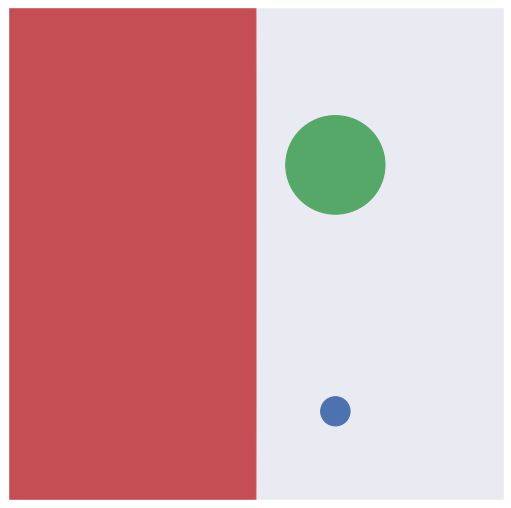

In [ ]:
print(f"{exoplanets[exoplanets.pl_rade == exoplanets.pl_rade.max()].pl_name.to_string(index=False)} is the largest known exoplanet. It has a radius {int(exoplanets.pl_rade.max())} times bigger than Earth's.")
print(f"{exoplanets[exoplanets.pl_rade == exoplanets.pl_rade.min()].pl_name.to_string(index=False)} is the smallest. It has a radius {exoplanets.pl_rade.min()*100:.3}% that of Earth's. That is smaller than Mercury!")
print(f"{exoplanets[exoplanets.pl_rade == exoplanets.pl_rade.max()].pl_name.to_string(index=False)} (red), Earth (green), and {exoplanets[exoplanets.pl_rade == exoplanets.pl_rade.min()].pl_name.to_string(index=False)} (blue):")
plt.figure(figsize=(8, 8), dpi=80)
circle1 = plt.Circle((-449.5, 0.5), 450, color='r')
circle2 = plt.Circle((0.66, 0.68), 0.1, color='g')
circle3 = plt.Circle((0.66, 0.18), 0.1*exoplanets.pl_rade.min(), color='b')
plt.gca().add_patch(circle1).axes.get_xaxis().set_visible(False)
plt.gca().add_patch(circle2).axes.get_yaxis().set_visible(False)
plt.gca().add_patch(circle3);

##### **Most and Least Massive, & Escape Velocity**

In [ ]:
print(f"{exoplanets[exoplanets.pl_bmasse == exoplanets.pl_bmasse.max()].pl_name.to_string(index=False)} is the most massive known exoplanet. It is {exoplanets.pl_bmasse.max()} times heavier than Earth.")
print(f"It also has the highest escape velocity, at {exoplanets.pl_escv.max()*11.2:.5} km/s, {exoplanets.pl_escv.max():.4} times larger than Earth's. ")

print(f"{exoplanets[exoplanets.pl_bmasse == exoplanets.pl_bmasse.min()].pl_name.to_string(index=False)} is the least massive exoplanet. It is {exoplanets.pl_bmasse.min()*100:.8}% the mass of the Earth.")
print(f"It however, does not have the lowest escape velocity. That title goes to {exoplanets[exoplanets.pl_escv == exoplanets.pl_escv.min()].pl_name.to_string(index=False)} with an escape velocity of {exoplanets.pl_escv.min()*11.2:.5} km/s, {exoplanets.pl_escv.min()*100:.3}% of Earth's. ")

PH2 b is the most massive known exoplanet. It is 25426.4 times heavier than Earth.
It also has the highest escape velocity, at 583.15 km/s, 52.07 times larger than Earth's. 
PSR B1257+12 b is the least massive exoplanet. It is 2.0% the mass of the Earth.
It however, does not have the lowest escape velocity. That title goes to Kepler-444 e with an escape velocity of 1.0551 km/s, 9.42% of Earth's. 


##### **Most Eccentric Orbit**

HD 20782 b has the highest eccentricity at 0.95.
It goes from 2.6616 AU at its farthest, to 0.068 AU at the closest.
The red dot represents the star while the blue elipse represents the orbit of HD 20782 b


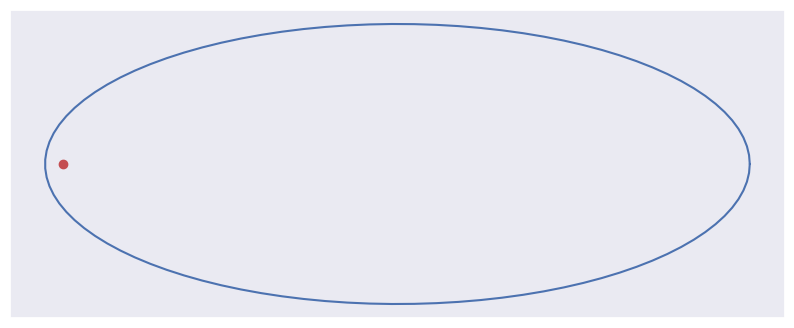

In [ ]:
print(f"{exoplanets[exoplanets.pl_orbeccen == exoplanets.pl_orbeccen.max()].pl_name.to_string(index=False)} has the highest eccentricity at {exoplanets.pl_orbeccen.max()}.")
print(f"It goes from {(exoplanets.pl_orbeccen.max()+1)*float(exoplanets[exoplanets.pl_orbeccen == exoplanets.pl_orbeccen.max()].pl_orbsmax):.5} AU at its farthest, to {(1-exoplanets.pl_orbeccen.max())*float(exoplanets[exoplanets.pl_orbeccen == exoplanets.pl_orbeccen.max()].pl_orbsmax):.2} AU at the closest.")
print(f"The red dot represents the star while the blue elipse represents the orbit of {exoplanets[exoplanets.pl_orbeccen == exoplanets.pl_orbeccen.max()].pl_name.to_string(index=False)}")
u=1     #x-position of the center
v=0.5    #y-position of the center
a=2     #radius on the x-axis
b=0.1561    #radius on the y-axis
t = np.linspace(0, 2*pi, 100)
plt.plot( u+a*np.cos(t) , v+b*np.sin(t) )
plt.plot(-0.90035,0.5, "ro")
plt.grid(color='lightgray',linestyle='--')
ax = plt.gca()
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
ax.grid(False)
plt.show()

##### **Hottest**

In [ ]:
print(f"{exoplanets[exoplanets.pl_eqt == exoplanets.pl_eqt.max()].pl_name.to_string(index=False)} has the highest equilibrium temperature at {int(exoplanets.pl_eqt.max())}K, or {int(exoplanets.pl_eqt.max())-273} degrees celsius.")
print(f"That is {int(exoplanets.pl_eqt.max()) - 5778} degrees hotter than the surface of our Sun!")

KOI-55 b has the highest equilibrium temperature at 7105K, or 6832 degrees celsius.
That is 1327 degrees hotter than the surface of our Sun!


##### **Highest surface gravity**

In [ ]:
print(f"{exoplanets[exoplanets.pl_sug == exoplanets.pl_sug.max()].pl_name.to_string(index=False)} has the highest surface gravity, at {int(exoplanets.pl_sug.max())}gs.")

K2-137 b has the highest surface gravity, at 387gs.


##### **Most and least dense**

In [ ]:
print(f"{exoplanets[exoplanets.pl_dens == exoplanets.pl_dens.max()].pl_name.to_string(index=False)} is the densest known exoplanet. It is {int(exoplanets.pl_dens.max())} times denser than Earth.")
print(f"{exoplanets[exoplanets.pl_dens == exoplanets.pl_dens.min()].pl_name.to_string(index=False)} is the least dense exoplanet. It is {exoplanets.pl_dens.min()*100:.3}% Earth's density.")

KOI-4777.01 is the densest known exoplanet. It is 747 times denser than Earth.
Kepler-444 e is the least dense exoplanet. It is 0.00699% Earth's density.


### **Count Plots**

Lets plot the exoplanet systems according to their distance and discovery year. Note that one parces equals 3.26156 light-years.

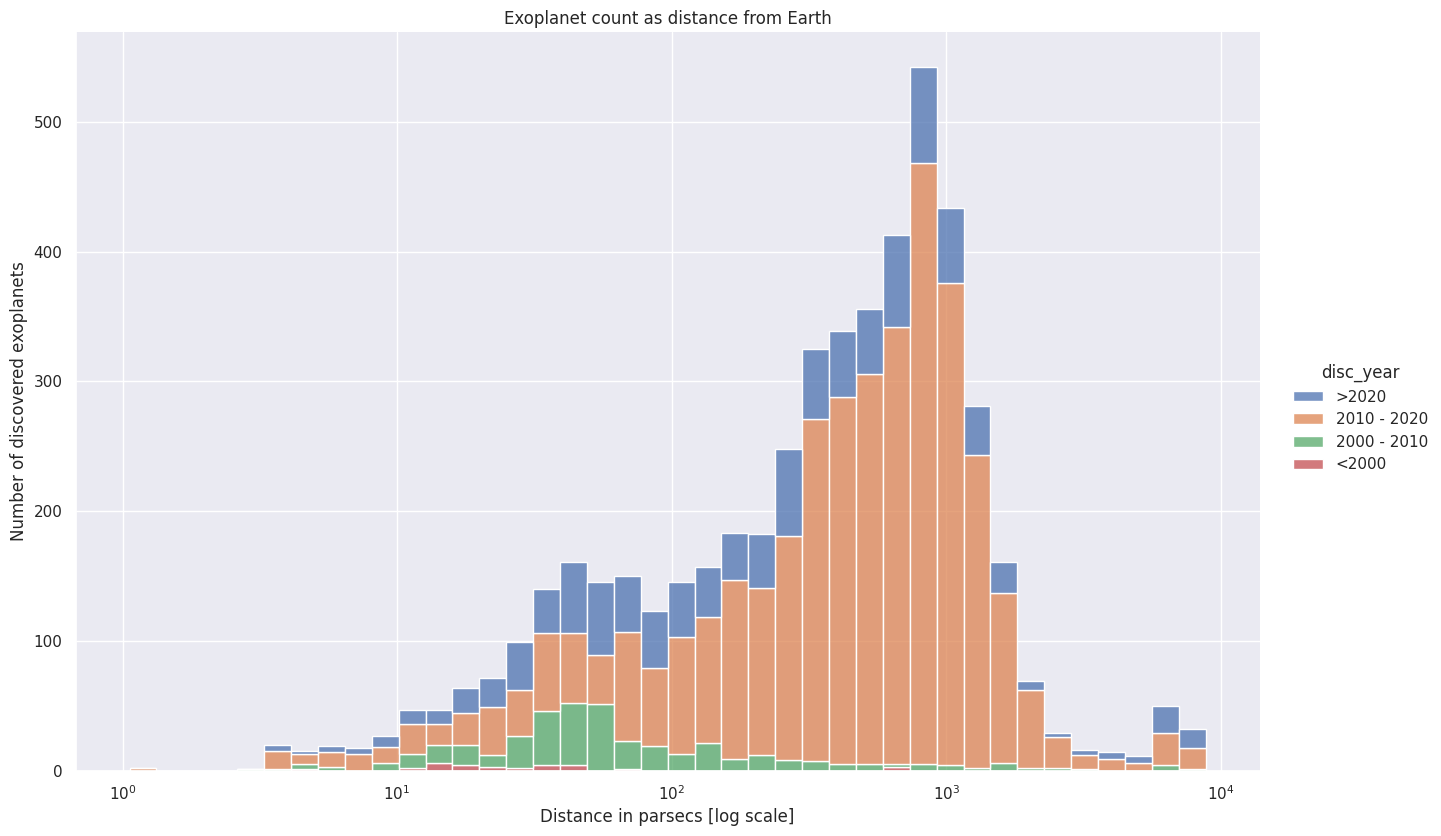

In [ ]:
temp1 = exoplanets.sort_values(by=["disc_year"], ascending=False).copy()
temp1.disc_year = temp1.disc_year.apply(lambda x: "<2000" if (x<2000) else ("2000 - 2010" if (x<2010) else ("2010 - 2020" if (x < 2020) else ">2020"))).copy()
ax = sns.displot(temp1, x="sy_dist", log_scale=True, height=8.3, aspect=13/8.3, hue="disc_year", multiple="stack")
ax.set(xlabel='Distance in parsecs [log scale]', ylabel='Number of discovered exoplanets', title="Exoplanet count as distance from Earth")
plt.show()

The count plot per year:

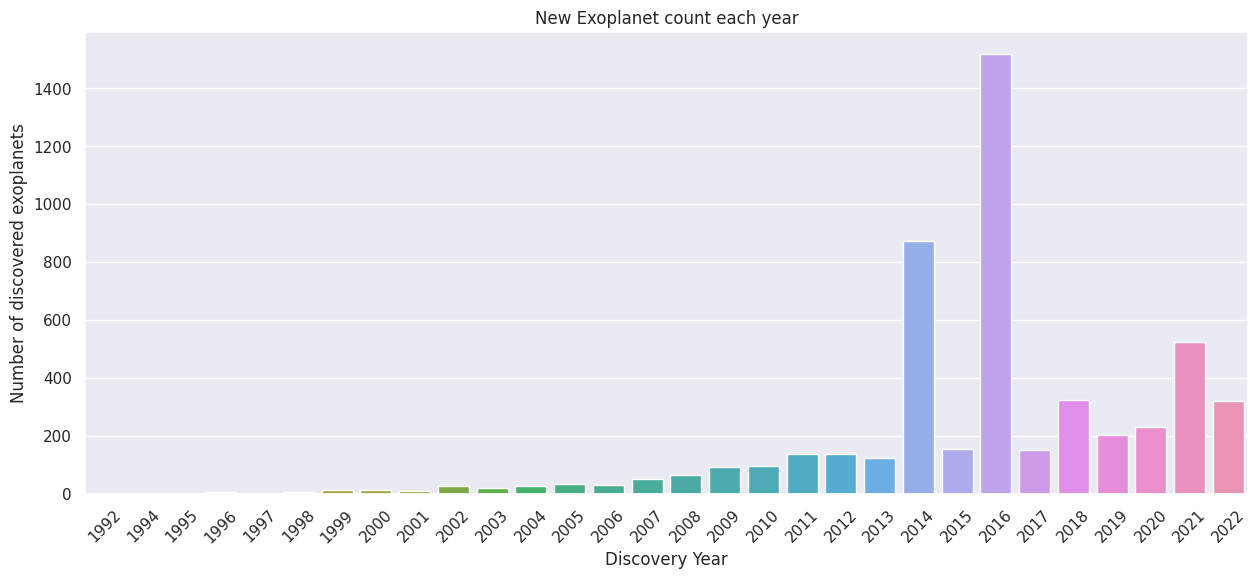

In [ ]:
temp1 = exoplanets.sort_values(by=["disc_year"], ascending=True).copy()
fig, ax = plt.subplots()
plt.gcf().set_size_inches((15, 6))

ax = sns.countplot(x=temp1.disc_year.astype("int16"))
ax.set(xlabel='Discovery Year', ylabel='Number of discovered exoplanets', title="New Exoplanet count each year")
plt.xticks(rotation=45)
plt.show()

Why do we see a large jump in newly discovered exoplanets in 2014 and 2016? Because the Kepler space telescope responsible for the vast majority of exoplanet discoveries, released its data in those two years. We also see another uptick in 2018, when Kepler released its final data before being deactivated.

Let’s take a look at the count plot of discovery facilities;

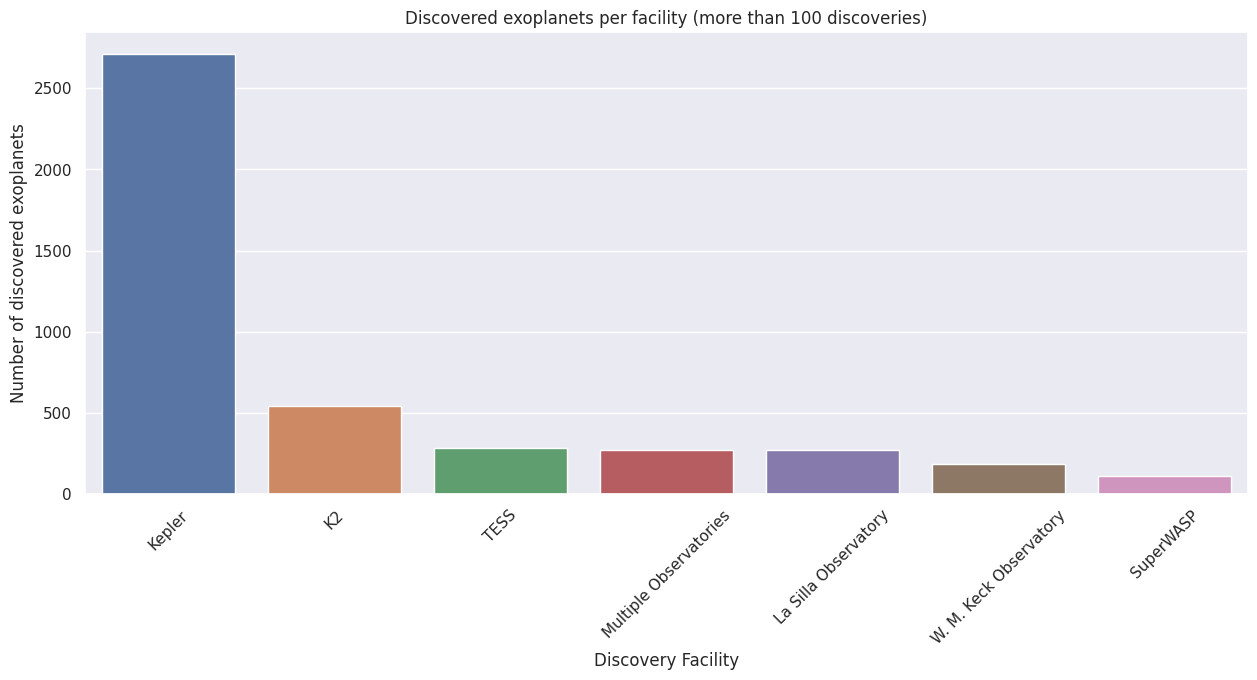

In [ ]:
temp1 = exoplanets.groupby("disc_facility").pl_name.count()
temp1 = temp1.reset_index()
temp1.sort_values(by=["pl_name"], ascending=False, inplace=True)
temp1.disc_facility = temp1.disc_facility.apply(lambda x: ("TESS") if x== "Transiting Exoplanet Survey Satellite (TESS)" else x)
temp1 = temp1[temp1['pl_name'] > 100]

fig, ax = plt.subplots()
plt.gcf().set_size_inches((15, 6))

ax = sns.barplot(data=temp1, x="disc_facility", y="pl_name")
ax.set(xlabel='Discovery Facility', ylabel='Number of discovered exoplanets', title="Discovered exoplanets per facility (more than 100 discoveries)")
plt.xticks(rotation=45);

And the count plot of discovery methods;

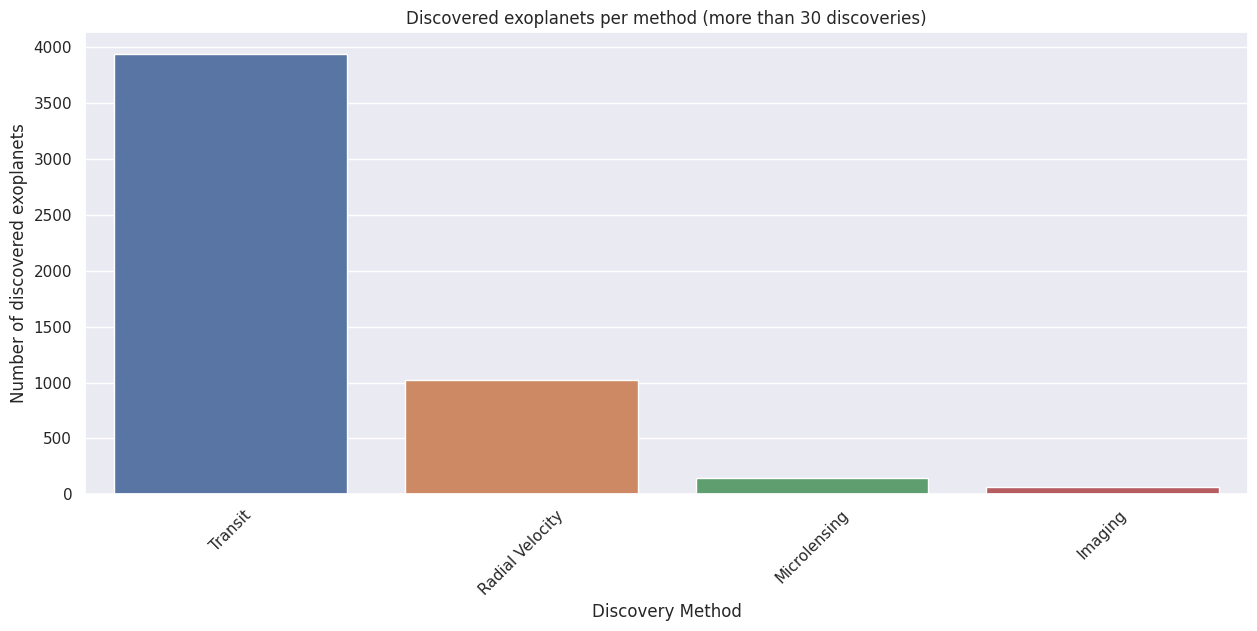

In [ ]:
temp1 = exoplanets.groupby("discoverymethod").pl_name.count()
temp1 = temp1.reset_index()
temp1.sort_values(by=["pl_name"], ascending=False, inplace=True)
temp1 = temp1[temp1['pl_name'] > 30]

fig, ax = plt.subplots()
plt.gcf().set_size_inches((15, 6))

ax = sns.barplot(data=temp1, x="discoverymethod", y="pl_name")
ax.set(xlabel='Discovery Method', ylabel='Number of discovered exoplanets', title="Discovered exoplanets per method (more than 30 discoveries)")
plt.xticks(rotation=45);

Transit timing is the most common method of discovering exoplanets. It consists of staring at a star for long periods of time, and watching for periodic dips in the star’s brightness caused by a transiting exoplanet. This introduces a strong discovery bias towards small stars (whose light can more easily be blocked), larger planets (that block more of their stats light), and shorter period planets (because they transit more often).

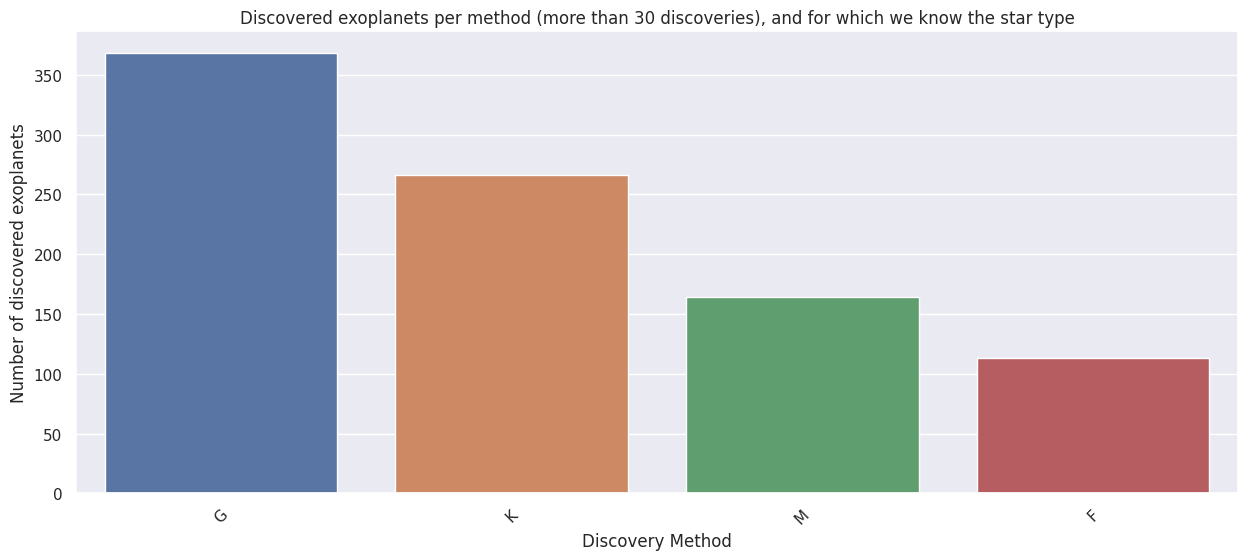

In [ ]:
temp1 = exoplanets.copy()
temp1.st_spectype = temp1.st_spectype.str[:1]
temp1 = temp1.groupby("st_spectype").pl_name.count()
temp1 = temp1.reset_index()
temp1.sort_values(by=["pl_name"], ascending=False, inplace=True)
temp1 = temp1[temp1['pl_name'] > 30]

fig, ax = plt.subplots()
plt.gcf().set_size_inches((15, 6))

ax = sns.barplot(data=temp1, x="st_spectype", y="pl_name")
ax.set(xlabel='Discovery Method', ylabel='Number of discovered exoplanets', title="Discovered exoplanets per method (more than 30 discoveries), and for which we know the star type")
plt.xticks(rotation=45);

### **Data correlation**

<ipython-input-66-f26ca5112138>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  temp1 = exoplanets.corr(method='pearson').where(np.tril(np.ones(exoplanets.corr(method='pearson').shape)).astype(bool))


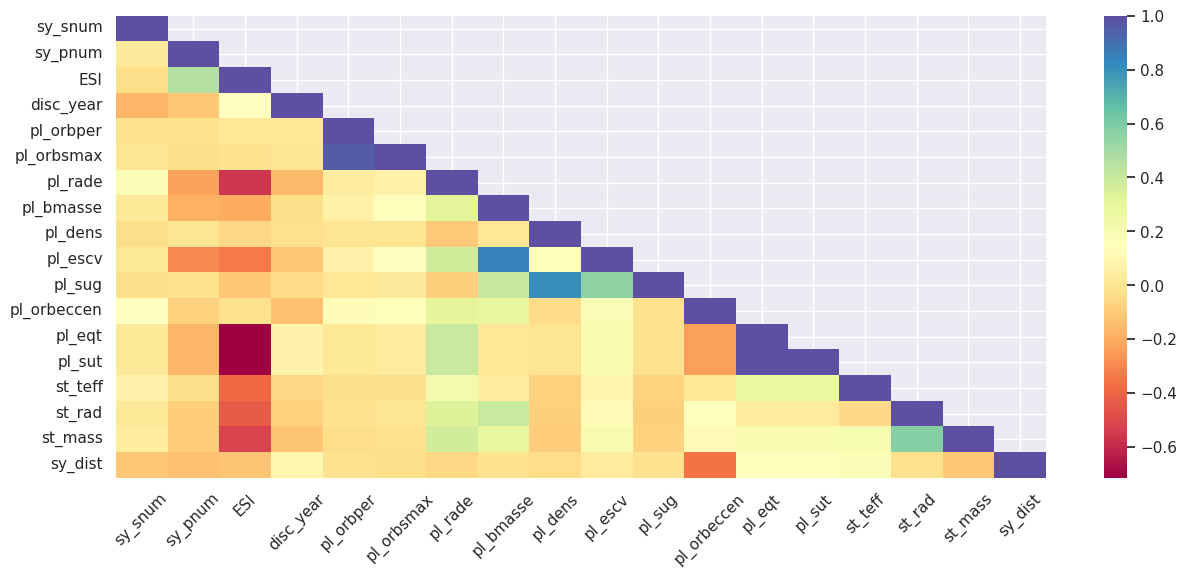

In [ ]:
temp1 = exoplanets.corr(method='pearson').where(np.tril(np.ones(exoplanets.corr(method='pearson').shape)).astype(bool))
fig, ax = plt.subplots(figsize=(15,6))
hmap=sns.heatmap(temp1,cmap="Spectral")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45);

We see several features which are highly correlated. Such as equilibrium temperature (pl_eqt) and surface temperature (pl_sut) which makes a lot of sense, as we used a linear equation to connect the two. Planetary density (pl_dens) and planetary escape velocity (pl_escv) are similarly connected - as the density determines the velocity.


Observation 1: An interesting observation concerns the Earth similarity index (ESI) and the number of other planets found in the planetary system (sy_pnum). This suggests that more habitable planets, or those that are more earth-like, have a higher chance of forming with other planetary companions. This meshes well with the numerous theories that the large gas giants such as Jupiter and Saturn, played key roles in shepherding the formation of the Earth. And other exoplanets might do the same for their system’s most habitable planets.


Observation 2: Another point to consider is the negative correlation between the distance to the exoplanet (sy_dist) and its orbital eccentricity (pl_orbeccen). We see this as the main discovery technique with which we can discover the eccentricity, is the radial velocity method. Where we measure the small changes in the motion of the parent star. These miniscule changes become much harder to detect with distance, and this is an example of selection bias. It is not that planets become less eccentric with distance from the earth, but our telescopes are not sensitive enough to probe those distant worlds in such a way as to reveal the most eccentric ones.


### **Clustering**

Exoplanets can be best clustered using density and radius. We will be using Spectral Clustering, and focusing on planets with a density less than 2 times the Earth’s, and a radius less than 16 times the Earth’s.

First, we will take a look at all the exoplanets in this range, by plotting them onto a scatter plot. We will also load in the planets of our Solar System as a comparison.

In [ ]:
temp1 = pd.DataFrame()
temp1["pl_dens"]=exoplanets[(exoplanets.pl_dens < 100000)].pl_dens
temp1["pl_rade"]=exoplanets[(exoplanets.pl_dens < 100000)].pl_rade

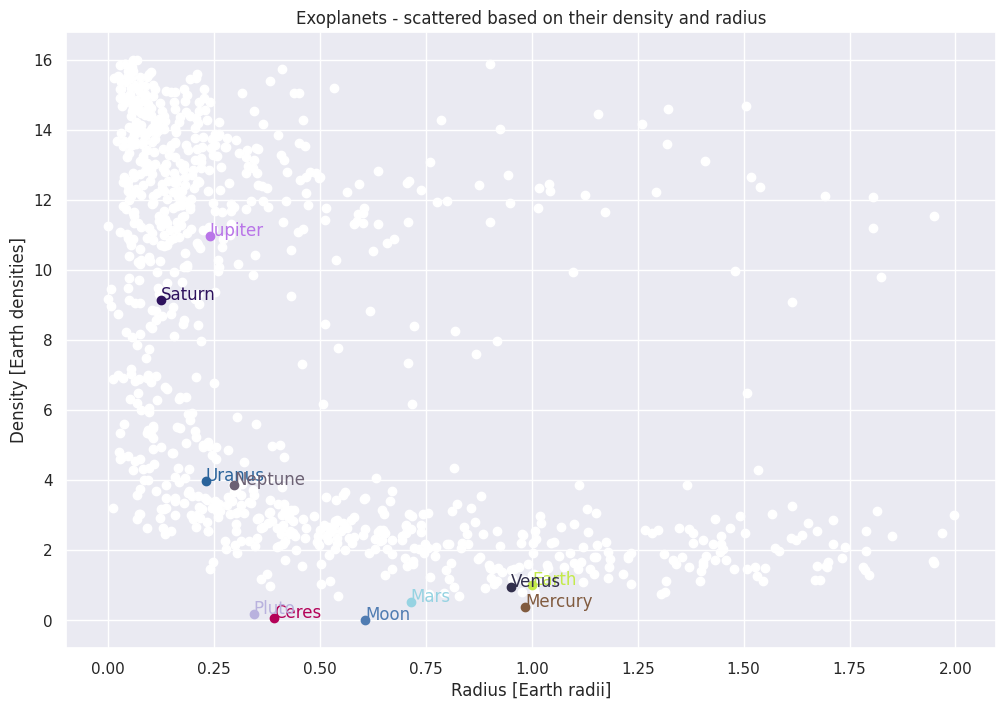

In [ ]:
fig, ax = plt.subplots()
plt.gcf().set_size_inches((12, 8))

upperDenslimit = 2
upperRadelimit = 16

ax.scatter(temp1[(temp1.pl_dens<upperDenslimit) & (temp1.pl_rade<upperRadelimit)].pl_dens, temp1[(temp1.pl_dens<upperDenslimit) & (temp1.pl_rade<upperRadelimit)].pl_rade, color = 'white');

color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(12)]

for ind in solData.index:
  ax.scatter(solData['pl_dens'][ind],solData['pl_rade'][ind],c=color[ind])
  ax.annotate(solData['pl_name'][ind], (solData['pl_dens'][ind],solData['pl_rade'][ind]), c=color[ind])

ax.set(xlabel='Radius [Earth radii]', ylabel='Density [Earth densities]', title="Exoplanets - scattered based on their density and radius");

Now we will cluster these datapoints into 6 clusters.

In [ ]:
temp2 = pd.DataFrame()
temp2["pl_dens"] = temp1[(temp1.pl_dens<upperDenslimit) & (temp1.pl_rade<upperRadelimit)].pl_dens
temp2["pl_rade"] = temp1[(temp1.pl_dens<upperDenslimit) & (temp1.pl_rade<upperRadelimit)].pl_rade

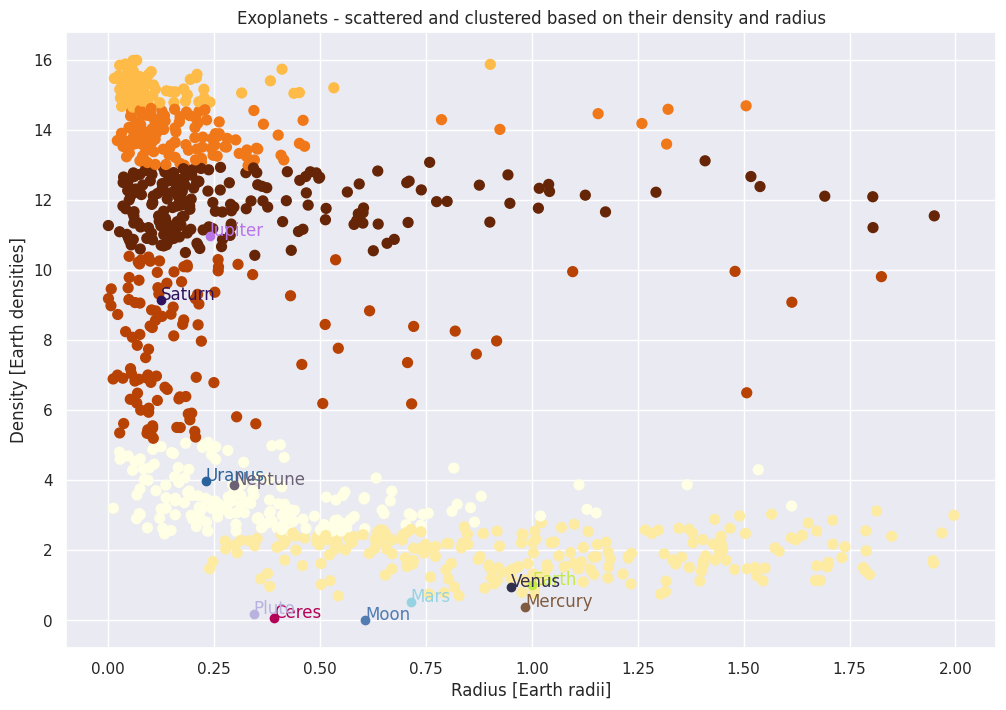

In [ ]:
fig, ax = plt.subplots()

plt.gcf().set_size_inches((12, 8))
model = SpectralClustering(n_clusters=6, affinity='nearest_neighbors',
                           assign_labels='kmeans')
labels = model.fit_predict(temp2)
ax.scatter(temp2.pl_dens, temp2.pl_rade, c=labels, s=50, cmap='YlOrBr');
for ind in solData.index:
  ax.scatter(solData['pl_dens'][ind],solData['pl_rade'][ind],c=color[ind])
  ax.annotate(solData['pl_name'][ind], (solData['pl_dens'][ind],solData['pl_rade'][ind]), c=color[ind])

ax.set(xlabel='Radius [Earth radii]', ylabel='Density [Earth densities]', title="Exoplanets - scattered and clustered based on their density and radius");

We clearly see the separation between the planet types within our own solar system.

1.   Earth, Venus, Mars and Mercury are all in the “lowest” cluster. This can be though of as the Terrestrial Cluster.
2. Uranus and Neptune are in their own Ice Giant Cluster.
3. As a Gas Giant with an extremely low density (lower than water’s), Saturn belongs in the third cluster, the Puff Planet Cluster.
4. Jupiter is the largest Gas Giant, and belongs in his own cluster, the true Gas Giant Cluster.
5. & 6. The clusters above the Gas Giant, contains planets whose masses put Jupiter’s to shame. We have no planets in this range within our own planetary system.

### **Classification**

We will manually set ranges and classes for variables such as mass, temperature and density, as proposed in this paper:

https://bit.ly/3jSfJ6M

I have used a modified system for classification, taking into account the "unknown densities" - densities many hundreds of times above Earth's.

In [ ]:
def classify(value, array):

  i = 0

  if value:
    while (value > array[1][i]) & (i <= len(array[1])):
      i = i + 1
    planetClass = array[0][i]
  else:
    planetClass = "?"

  return planetClass

Each planet is classified based on the modified values presented in the paper. 

In [ ]:
exoplanets["massClass"] = exoplanets.apply(lambda x: classify(x.pl_bmasse, [["?", "M", "E", "N", "J", "S", "D"],[0, 0.6358,9.537,190.744,1589.53,4768.6, 100000000]]), axis=1)
exoplanets["tempClass"] = exoplanets.apply(lambda x: classify(x.pl_eqt, [["?", "F", "A", "W", "G", "R"],[0, 245, 310, 600, 1000, 100000000]]), axis=1)
exoplanets["planetClass"] = exoplanets.apply(lambda x: classify(x.pl_dens, [["?", "p", "g", "t", "x"],[0, 0.1, 0.3, 1.5, 100000000]]), axis=1)

Lets take a look at the count plots for Mass, Temperature, and Density:

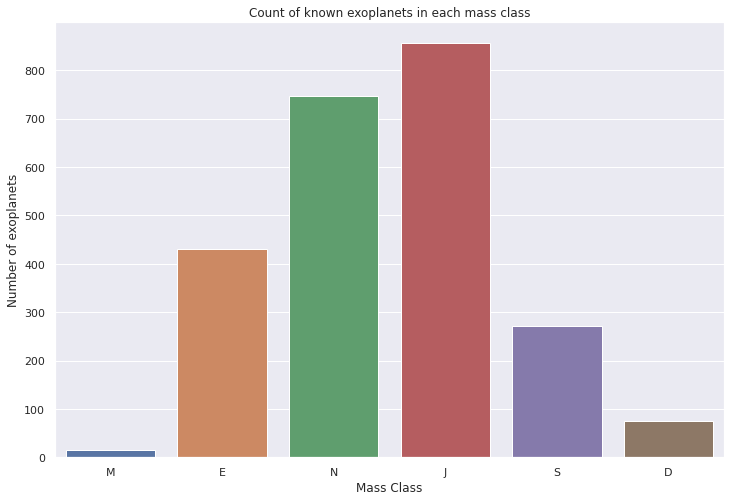

In [ ]:
fig, ax = plt.subplots()
plt.gcf().set_size_inches((12, 8))

temp1 = exoplanets[exoplanets.massClass != "?"].copy()

ax = sns.countplot(x="massClass", data=temp1, order=["M", "E", "N", "J", "S", "D"])
ax.set(xlabel='Mass Class', ylabel='Number of exoplanets', title="Count of known exoplanets in each mass class");

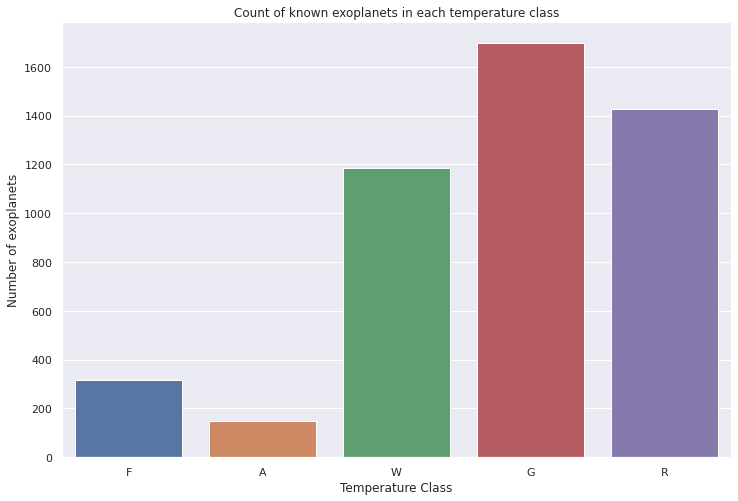

In [ ]:
fig, ax = plt.subplots()
plt.gcf().set_size_inches((12, 8))

temp1 = exoplanets[exoplanets.tempClass != "?"].copy()

ax = sns.countplot(x="tempClass", data=temp1, order=["F", "A", "W", "G", "R"])
ax.set(xlabel='Temperature Class', ylabel='Number of exoplanets', title="Count of known exoplanets in each temperature class");

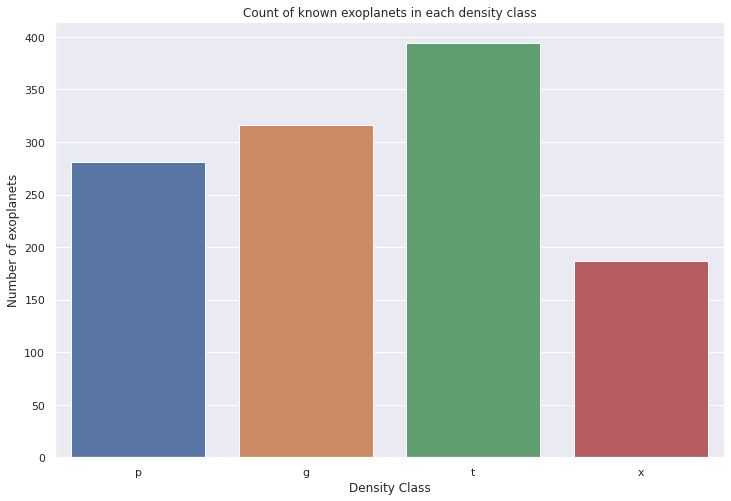

In [ ]:
fig, ax = plt.subplots()
plt.gcf().set_size_inches((12, 8))

temp1 = exoplanets[exoplanets.planetClass != "?"].copy()

ax = sns.countplot(x="planetClass", data=temp1, order=["p", "g", "t", "x"])
ax.set(xlabel='Density Class', ylabel='Number of exoplanets', title="Count of known exoplanets in each density class");

Are there any exoplanets with the same classification as Earth? We are looking for a planet with a class of “EAt”.

In [ ]:
exoplanets[(exoplanets.massClass == "E") & (exoplanets.tempClass == "A") & (exoplanets.planetClass == "t")]

,pl_name,hostname,sy_snum,sy_pnum,ESI,discoverymethod,disc_year,disc_facility,pl_orbper,pl_orbsmax,pl_rade,pl_bmasse,pl_dens,pl_escv,pl_sug,pl_orbeccen,pl_eqt,pl_sut,st_spectype,st_teff,st_rad,st_mass,sy_dist,ttv_flag,massClass,tempClass,planetClass
398,K2-18 b,K2-18,1.0,2.0,0.806230,Transit,2015.0,K2,32.938156,0.147933,2.532000,8.503333,0.523841,1.832579,1.326,0.210000,260.0,294.610,None,3464.0,0.44,0.407143,38.0266,NaN,E,A,t
438,K2-3 d,K2-3,1.0,3.0,0.812223,Transit,2015.0,K2,44.556460,0.203360,1.456667,2.800070,0.905920,1.386450,1.320,0.000000,291.0,328.586,M0,3896.0,0.56,0.600000,44.0727,NaN,E,A,t
612,L 98-59 d,L 98-59,1.0,4.0,0.705965,Transit,2019.0,Transiting Exoplanet Survey Satellite (TESS),7.450732,0.050400,1.722000,2.125000,0.416161,1.110869,0.717,0.121333,307.0,346.122,None,3469.0,0.31,0.296667,10.6194,NaN,E,A,t
4313,TRAPPIST-1 e,TRAPPIST-1,1.0,7.0,0.941255,Transit,2017.0,Multiple Observatories,6.099565,0.029240,0.920000,0.692000,0.888677,0.867280,0.818,0.005100,250.0,283.650,M8,2520.0,0.12,0.090000,12.4664,True,E,A,t


All these worlds have ESI higher than any other object in the solar system besides Earth.

### **Predicting the next milestones in exoplanet discoveries**

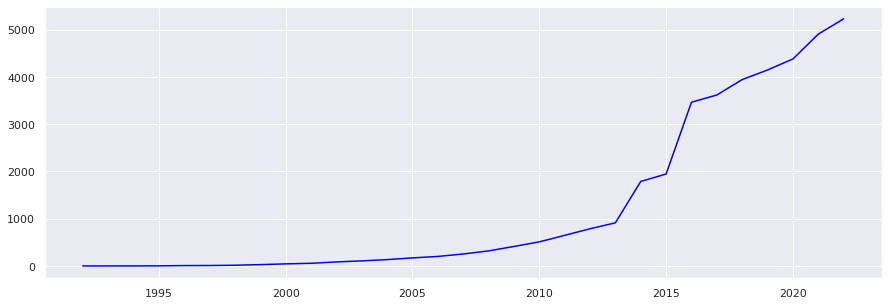

In [ ]:
temp2 = exoplanets.groupby("disc_year").pl_name.count()
temp1 = temp2.cumsum()
plt.figure(figsize=(15,5))
plt.plot(temp1, c="blue")
plt.show()

In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression

temp2 = temp1
temp2 = temp2.to_frame()
temp2.rename(columns={'pl_name': 'y'}, inplace=True)
temp2["log_y"] = np.log(temp2.y)
temp2["year"] = temp2.index - 1991

# Create a numpy array of data:
x = temp2.year.to_numpy().reshape((-1, 1))
y = temp2.log_y.to_numpy()

# Create an instance of a linear regression model and fit it to the data with the fit() function:
model = LinearRegression().fit(x, y)

# The following section will get results by interpreting the created instance: 

# Obtain the coefficient of determination by calling the model with the score() function, then print the coefficient:
r_sq = model.score(x, y)
print('coefficient of determination:', r_sq)

# Print the Intercept:
print('intercept:', model.intercept_)

# Print the Slope:
print('slope:', model.coef_)

# Predict a Response and print it:
y_pred = model.predict(x)
print('Predicted response:', y_pred, sep='\n')

coefficient of determination: 0.9748802613653331
intercept: 1.0392566604749103
slope: [0.2679142]
Predicted response:
[1.30717086 1.84299927 2.11091347 2.37882768 2.64674188 2.91465609
 3.18257029 3.45048449 3.7183987  3.9863129  4.2542271  4.52214131
 4.79005551 5.05796971 5.32588392 5.59379812 5.86171232 6.12962653
 6.39754073 6.66545493 6.93336914 7.20128334 7.46919754 7.73711175
 8.00502595 8.27294016 8.54085436 8.80876856 9.07668277 9.34459697]


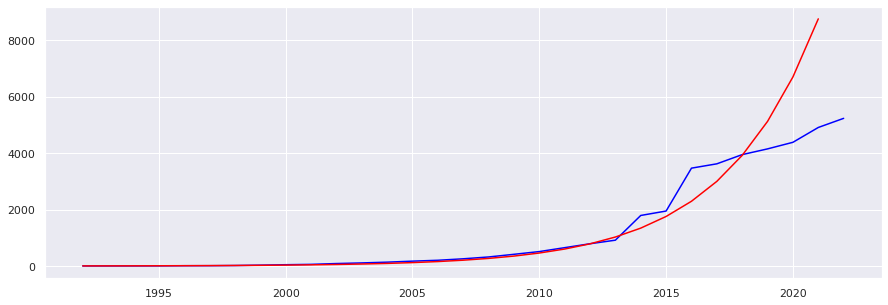

In [ ]:
x = np.arange(1,100).reshape(-1,1)
y_pred = model.predict(x)
temp1=pd.DataFrame(x+1991, y_pred)
temp1 = temp1.reset_index()
temp1 = temp1.rename(columns={"index": "count"})
temp1["exo_count"] = temp1["count"].apply(lambda x: math.exp(x))
temp1.pop("count")
temp1 = temp1.rename(columns={0: "year"})
temp1 = temp1.set_index('year')
plt.figure(figsize=(15,5))
plt.plot(exoplanets.groupby("disc_year").pl_name.count().cumsum(), c ="blue")
plt.plot(temp1[:30], c ="red")
plt.show()

In [ ]:
print("The model predicts:")
target = 10000
print(f"We will reach {target} known exoplanets by the end of {temp1['exo_count'].gt(target).idxmax()}.")
target = 100000
print(f"We will reach {target} known exoplanets by the end of {temp1['exo_count'].gt(target).idxmax()}.")
target = 1000000
print(f"We will reach {target} known exoplanets by the end of {temp1['exo_count'].gt(target).idxmax()}.")
target = 10000000
print(f"We will reach {target} known exoplanets by the end of {temp1['exo_count'].gt(target).idxmax()}.")
target = 100000000
print(f"We will reach {target} known exoplanets by the end of {temp1['exo_count'].gt(target).idxmax()}.")
target = 1000000000
print(f"We will reach {target} known exoplanets by the end of {temp1['exo_count'].gt(target).idxmax()}.")

The model predicts:
We will reach 10000 known exoplanets by the end of 2022.
We will reach 100000 known exoplanets by the end of 2031.
We will reach 1000000 known exoplanets by the end of 2039.
We will reach 10000000 known exoplanets by the end of 2048.
We will reach 100000000 known exoplanets by the end of 2056.
We will reach 1000000000 known exoplanets by the end of 2065.


Even though our predictions for the year 2022 are already wrong, the model confirms the findings of René Heller and László L. Kiss in their paper *“Exoplanet Vision 2050”* where they predict 100 000 000 known exoplanets by that year. Our model predicts the 100 000 000th planet will be discovered sometime in the latter half of 2056

*Exoplanet Vision 2050*: https://arxiv.org/pdf/1911.12114.pdf

#### **When will humanity discover every single planet in our Galaxy?**

Predictions for the exact number of planets within the Milky Way range from 100 to 200 billion. And if current trends continue:

In [ ]:
print(f"Humanity will discover all of the Milky Way's planets sometime between {temp1['exo_count'].gt(100000000000).idxmax()} and {temp1['exo_count'].gt(200000000000).idxmax()} ")

Humanity will discover all of the Milky Way's planets sometime between 2082 and 2085 
